# Laboratory work #3

Import all significant libraries for this project.

In [16]:
# Import TensorFlow & Keras Libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.layers import Conv2D, MaxPool2D, RNN, GlobalMaxPool2D
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2 as l2_reg
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.utils import image_dataset_from_directory

# Import scikit-learn libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Import libraries for text cleaning
import re
import string
import nltk
from nltk.corpus import stopwords

# Import other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Who\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Exercise 1

#### Downloading Dataset
Our dataset is Possible Asteroid Impacts with Earth (from [kaggle](https://www.kaggle.com/datasets/nasa/asteroid-impacts))

### Preprocessing Dataset

In [2]:
# Loading dataset to pandas DataFrame
asteroid_df = pd.read_csv("datasets\\asteroid_dataset\\asteroid_classification.csv")

In [3]:
# Drop unnecessary columns for analysis from the dataframe
asteroid_df.drop(["Object Name", "Epoch (TDB)", "Perihelion Argument (deg)", "Node Longitude (deg)",
                  "Mean Anomoly (deg)", "Perihelion Distance (AU)", "Aphelion Distance (AU)",
                  "Minimum Orbit Intersection Distance (AU)", "Orbital Reference"], axis=1, inplace=True)
print(asteroid_df.columns)

Index(['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity',
       'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude'],
      dtype='object')


In [4]:
# Drop null values of dataframe as we have only one null value
asteroid_df.dropna(inplace=True)
asteroid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15634 entries, 0 to 15634
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Object Classification    15634 non-null  object 
 1   Orbit Axis (AU)          15634 non-null  float64
 2   Orbit Eccentricity       15634 non-null  float64
 3   Orbit Inclination (deg)  15634 non-null  float64
 4   Orbital Period (yr)      15634 non-null  float64
 5   Asteroid Magnitude       15634 non-null  float64
dtypes: float64(5), object(1)
memory usage: 855.0+ KB


In [5]:
# Change class names
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Apollo Asteroid" ,
                                          "Apollo", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Aten Asteroid",
                                          "Aten", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Amor Asteroid",
                                          "Amor", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Apohele Asteroid",
                                          "Apohele", inplace=True)
# Drop unnecessary class
necessary_class = ["Apollo", "Aten", "Amor"]
asteroid_df = asteroid_df[asteroid_df["Object Classification"].isin(necessary_class)]

In [6]:
def remove_outliers(dataframe, features):
    """Function to remove the outliers;
    :param dataframe: pandas DataFrame with data;
    :param features: list with features from dataframe.
    """
    # Copy dataframe to another variable
    dataframe_copy = dataframe.copy()

    # Iterate through features
    for feature in features:
        if dataframe[feature].dtype == object:
            continue
        # Calculate q1, q3 and iqr
        q3 = dataframe[feature].quantile(0.75)
        q1 = dataframe[feature].quantile(0.25)
        iqr = q3 - q1

        # Get local minimum and maximum
        local_min = q1 - (1.5 * iqr)
        local_max = q3 + (1.5 * iqr)

        # Remove the outliers
        dataframe_copy = dataframe_copy[(dataframe_copy[feature] >= local_min) &
                                        (dataframe_copy[feature] <= local_max)]

    return dataframe_copy

In [7]:
# Extract features from the df
asteroid_features = asteroid_df.columns.tolist()
print(asteroid_features)

['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity', 'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude']


In [8]:
# Remove outliers from the dataframe
asteroid_df = remove_outliers(asteroid_df, asteroid_features)

In [9]:
# View count of class names
print(asteroid_df.iloc[:, 0].value_counts())

Apollo    6651
Amor      5686
Aten       965
Name: Object Classification, dtype: int64


In [10]:
# Define number of classes
num_classes = len(necessary_class)

In [11]:
# Normalise dataset
norm_asteroid_df = asteroid_df.copy()
# apply normalization techniques
for column in norm_asteroid_df:
    if norm_asteroid_df[column].dtype == object:
        continue
    norm_asteroid_df[column] = norm_asteroid_df[column] / norm_asteroid_df[column].abs().max()
# View normalised dataset
print(norm_asteroid_df.head())

  Object Classification  Orbit Axis (AU)  Orbit Eccentricity  \
1                  Amor         0.807646            0.590282   
2                  Amor         0.758732            0.610967   
4                  Amor         0.587438            0.469295   
8                  Amor         0.570204            0.427279   
9                Apollo         0.418531            0.469619   

   Orbit Inclination (deg)  Orbital Period (yr)  Asteroid Magnitude  
1                 0.296677             0.727119            0.492063  
2                 0.239656             0.661017            0.425397  
4                 0.304293             0.450847            0.561905  
8                 0.216477             0.430508            0.419048  
9                 0.240286             0.271186            0.451746  


In [12]:
# Edit name of column "Object Classification" with _
# For using this name in next cell
number_asteroid_df = norm_asteroid_df.copy()
number_asteroid_df.rename(columns={"Object Classification": "Object_Classification"}, inplace=True)
# Replace string class to numbers
obj_class = {"Apollo": 0, "Aten": 1, "Amor": 2}
number_asteroid_df.Object_Classification = [obj_class[item] for item in number_asteroid_df.Object_Classification]
# View new dataset
print(number_asteroid_df.head())

   Object_Classification  Orbit Axis (AU)  Orbit Eccentricity  \
1                      2         0.807646            0.590282   
2                      2         0.758732            0.610967   
4                      2         0.587438            0.469295   
8                      2         0.570204            0.427279   
9                      0         0.418531            0.469619   

   Orbit Inclination (deg)  Orbital Period (yr)  Asteroid Magnitude  
1                 0.296677             0.727119            0.492063  
2                 0.239656             0.661017            0.425397  
4                 0.304293             0.450847            0.561905  
8                 0.216477             0.430508            0.419048  
9                 0.240286             0.271186            0.451746  


In [13]:
# One-hot Encoding the Object Classification Feature
one_hot = OneHotEncoder()
# Copy our dataset
onehot_asteroid_df = norm_asteroid_df.copy()
# Fitting one-hot encoder
encoded = one_hot.fit_transform(onehot_asteroid_df[["Object Classification"]])
onehot_asteroid_df[one_hot.categories_[0]] = encoded.toarray()
# Drop unnecessary "Object Classification" feature
onehot_asteroid_df.drop(["Object Classification"], axis=1, inplace=True)
print(onehot_asteroid_df.head())

   Orbit Axis (AU)  Orbit Eccentricity  Orbit Inclination (deg)  \
1         0.807646            0.590282                 0.296677   
2         0.758732            0.610967                 0.239656   
4         0.587438            0.469295                 0.304293   
8         0.570204            0.427279                 0.216477   
9         0.418531            0.469619                 0.240286   

   Orbital Period (yr)  Asteroid Magnitude  Amor  Apollo  Aten  
1             0.727119            0.492063   1.0     0.0   0.0  
2             0.661017            0.425397   1.0     0.0   0.0  
4             0.450847            0.561905   1.0     0.0   0.0  
8             0.430508            0.419048   1.0     0.0   0.0  
9             0.271186            0.451746   0.0     1.0   0.0  


In [14]:
# Change data type in one-hot encoded column
column_dtype_dict = {"Amor": int,
                     "Apollo": int,
                     "Aten": int}
norm_onehot_asteroid_df = onehot_asteroid_df.astype(column_dtype_dict)
print(norm_onehot_asteroid_df.dtypes)
print(norm_onehot_asteroid_df.head())

Orbit Axis (AU)            float64
Orbit Eccentricity         float64
Orbit Inclination (deg)    float64
Orbital Period (yr)        float64
Asteroid Magnitude         float64
Amor                         int32
Apollo                       int32
Aten                         int32
dtype: object
   Orbit Axis (AU)  Orbit Eccentricity  Orbit Inclination (deg)  \
1         0.807646            0.590282                 0.296677   
2         0.758732            0.610967                 0.239656   
4         0.587438            0.469295                 0.304293   
8         0.570204            0.427279                 0.216477   
9         0.418531            0.469619                 0.240286   

   Orbital Period (yr)  Asteroid Magnitude  Amor  Apollo  Aten  
1             0.727119            0.492063     1       0     0  
2             0.661017            0.425397     1       0     0  
4             0.450847            0.561905     1       0     0  
8             0.430508            0.419048 

### Split Dataset to Train & Test sets

In [14]:
# Split Categorical Dataset
x = norm_asteroid_df.drop(["Object Classification"], axis=1)
y = norm_asteroid_df["Object Classification"]
# Split to train test sets
catg_X_train, catg_X_test, catg_y_train, catg_y_test = train_test_split(x, y, test_size=0.20)

In [15]:
# Split Numeric Dataset
x = number_asteroid_df.drop(["Object_Classification"], axis=1)
y = number_asteroid_df["Object_Classification"]
# Split to train test sets
num_X_train, num_X_test, num_y_train, num_y_test = train_test_split(x, y, test_size=0.20)

In [15]:
# Split One-Hot Dataset
x = norm_onehot_asteroid_df.drop(["Apollo", "Aten", "Amor"], axis=1)
y = norm_onehot_asteroid_df[["Apollo", "Aten", "Amor"]]
# Split to train test sets
# oneh_X_train, oneh_X_valid, oneh_X_test = np.split(x.sample(frac=1), [int(0.8*len(x)), int(0.9*len(x))])
# oneh_y_train, oneh_y_valid, oneh_y_test = np.split(y.sample(frac=1), [int(0.8*len(y)), int(0.9*len(y))])
oneh_train, oneh_valid, oneh_test = np.split(norm_onehot_asteroid_df.sample(frac=1), [int(0.8*len(norm_onehot_asteroid_df)), int(0.9*len(norm_onehot_asteroid_df))])

In [71]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    """
    Function for converting dataframe var to tf dataset.
    :param dataframe:
    :param shuffle:
    :param batch_size:
    :return:
    """
    # Copy dataframe to new vars
    df = dataframe.copy()
    df = df.drop(["Apollo", "Aten", "Amor"], axis=1)
    labels = dataframe[["Apollo", "Aten", "Amor"]]
    # Convert dataframe with data to tensor with concrete dtype -- float32
    df = tf.constant(df, dtype=tf.float32)
    # Make TensorFlow Dataset
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    # Optimize TF Dataset for loading to model
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [72]:
# Define batch size variable
batch_size = 32
# Get TensorFlow Dataset object
train_ds = df_to_dataset(oneh_train, batch_size=batch_size)
valid_ds = df_to_dataset(oneh_valid, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(oneh_test, shuffle=False, batch_size=batch_size)

In [73]:
# View new train dataset
for onehot in train_ds.take(1):
    print(onehot)

(<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[0.691573  , 0.74822235, 0.05346096, 0.5762712 , 0.86031747],
       [0.74713033, 0.60881275, 0.23767088, 0.64576274, 0.6952381 ],
       [0.61165017, 0.52908856, 0.23881587, 0.4779661 , 0.7777778 ],
       [0.3599437 , 0.35811248, 0.3107529 , 0.21694915, 0.6920635 ],
       [0.51602435, 0.45593622, 0.32116282, 0.37118644, 0.74920636],
       [0.49398512, 0.4771601 , 0.10288757, 0.34745762, 0.85714287],
       [0.34473047, 0.37319544, 0.02777941, 0.20338982, 0.768254  ],
       [0.35721937, 0.37621203, 0.14390735, 0.21355931, 0.73968256],
       [0.33420062, 0.5287654 , 0.13169159, 0.19322033, 0.71746033],
       [0.5683063 , 0.38149107, 0.15756781, 0.42881355, 0.6507937 ],
       [0.41482753, 0.6149537 , 0.16654329, 0.2677966 , 0.7714286 ],
       [0.4875264 , 0.65513897, 0.69243616, 0.34067798, 0.7015873 ],
       [0.51841193, 0.6356389 , 0.69989526, 0.37288135, 0.584127  ],
       [0.33769017, 0.17420815, 0.6442519 , 0.1966101

### Build model

In [4]:
def model_compile(model, loss_func, learn_rate=0.001):
    """
    Help function for compiling model;
    :param model: built model;
    :param loss_func: loss function for compiling;
    :param learn_rate: learning rate for optimizer.
    """
    model.compile(loss=loss_func,
                  optimizer=Adam(learning_rate=learn_rate),
                  metrics=["accuracy"])

In [75]:
# Set Input layer for input data
input_shape = len(asteroid_features)-1
inputs = Input(shape=(input_shape,), name="model_inputs")

In [76]:
# Set Dense (Fully Connected) layer with 100 hidden unit and "relu" activation function
x = Dense(100, activation="relu")(inputs)
# Set another Dense layer with 10 hidden unit and "relu" activation function
x = Dense(10, activation="relu")(x)
# Set output layer with num_classes hidden unit and "sigmoid" activation function
outputs = Dense(num_classes, activation="sigmoid")(x)

In [77]:
# Define our model
onehot_model = Model(inputs, outputs, name="onehot_model")

In [78]:
# View summary of the model
onehot_model.summary()

Model: "onehot_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 5)]               0         
                                                                 
 dense_19 (Dense)            (None, 100)               600       
                                                                 
 dense_20 (Dense)            (None, 10)                1010      
                                                                 
 dense_21 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,643
Trainable params: 1,643
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Compile the model
model_compile(onehot_model, CategoricalCrossentropy())

### Fit model

In [80]:
# Fitting the model
onehot_history = onehot_model.fit(train_ds,
                                  batch_size=batch_size,
                                  epochs=10,
                                  validation_data=valid_ds,
                                  use_multiprocessing=True)

Epoch 1/10
333/333 [==============================] - 3s 4ms/step - loss: 0.7306 - accuracy: 0.6950 - val_loss: 0.5407 - val_accuracy: 0.7917
Epoch 2/10
333/333 [==============================] - 1s 4ms/step - loss: 0.4504 - accuracy: 0.8159 - val_loss: 0.3928 - val_accuracy: 0.8098
Epoch 3/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3297 - accuracy: 0.8551 - val_loss: 0.2794 - val_accuracy: 0.9038
Epoch 4/10
333/333 [==============================] - 1s 4ms/step - loss: 0.2540 - accuracy: 0.9100 - val_loss: 0.2196 - val_accuracy: 0.9308
Epoch 5/10
333/333 [==============================] - 1s 4ms/step - loss: 0.2061 - accuracy: 0.9354 - val_loss: 0.1861 - val_accuracy: 0.9338
Epoch 6/10
333/333 [==============================] - 1s 4ms/step - loss: 0.1825 - accuracy: 0.9387 - val_loss: 0.1567 - val_accuracy: 0.9549
Epoch 7/10
333/333 [==============================] - 1s 4ms/step - loss: 0.1591 - accuracy: 0.9492 - val_loss: 0.1404 - val_accuracy: 0.9624
Epoch 

### Evaluate model

In [82]:
loss, accuracy = onehot_model.evaluate(test_ds)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set = {accuracy}")

42/42 [==============================] - 0s 3ms/step - loss: 0.1219 - accuracy: 0.9609
Model loss on the test set: 0.12188560515642166
Model accuracy on the test set = 0.960931658744812


Last best result on this data is that:
**model** - GridSearch(SVM)
**result** - accuracy = 0.99

Now result is
**model** - Fully connected feed-forward network
**result** - accuracy = 0.96

In summary, we can say model (GridSearch(SVM)) have best fit on this data!

## Exercise 2

#### Downloading Dataset
Our dataset is Food Classification Dataset (from [kaggle]())

### Preprocessing Dataset

In [5]:
def prepare_ds(dataset, shuffle=False, batch=32):
    """
    Help function for prepare dataset for better performance;
    :param dataset: TensorFlow Dataset object;
    :param shuffle: bool for define make shuffle or not;
    :param batch: size of batch in dataset;
    :return: normalized and prepared dataset.
    """
    # Shuffle our dataset
    if shuffle:
        dataset.shuffle(buffer_size=len(dataset))
    # Batching our dataset
    dataset.batch(batch)
    # Augmenting our dataset
    norm_layer = Rescaling(1./255)
    ds = dataset.map(lambda x, y: (norm_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    image_batch, labels_batch = next(iter(ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)


def plot_loss_curves(history):
    """
    Function for plot the validation and training data separately
    :param history: history of loss curves from fitted model.
    :return: separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


In [6]:
# Define train and test dir
train_dir = pathlib.Path("datasets\\10_food_classes_all_data\\train\\")
test_dir = pathlib.Path("datasets\\10_food_classes_all_data\\test\\")

In [7]:
train_dir

WindowsPath('datasets/10_food_classes_all_data/train')

In [8]:
# Define some important variable
batch_size = 32
image_size = (224, 224)
random_seed = 17
# Set train and test datasets
train_ds = image_dataset_from_directory(train_dir,
                                        label_mode="categorical",
                                        seed=random_seed,
                                        image_size=image_size,
                                        batch_size=batch_size)
val_ds = image_dataset_from_directory(test_dir,
                                      label_mode="categorical",
                                      validation_split=0.5,
                                      subset="validation",
                                      seed=random_seed,
                                      image_size=image_size,
                                      batch_size=batch_size)
test_ds = image_dataset_from_directory(test_dir,
                                       label_mode="categorical",
                                       validation_split=0.5,
                                       subset="training",
                                       seed=random_seed,
                                       image_size=image_size,
                                       batch_size=batch_size)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Using 1250 files for validation.
Found 2500 files belonging to 10 classes.
Using 1250 files for training.


In [9]:
# View on train Dataset
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# View on test Dataset
next(iter(train_ds))

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
 array([[[[ 77.45918  , 101.77041  ,  62.       ],
          [ 77.994896 , 102.85715  ,  62.903065 ],
          [ 76.       , 102.15306  ,  63.07653  ],
          ...,
          [178.78587  , 204.2144   , 185.2144   ],
          [181.7143   , 204.7143   , 184.7143   ],
          [182.64282  , 205.64282  , 185.64282  ]],
 
         [[118.45409  , 136.76021  ,  94.78572  ],
          [115.9898   , 136.92348  ,  94.06633  ],
          [110.44388  , 132.12755  ,  91.       ],
          ...,
          [182.50015  , 207.92868  , 188.92868  ],
          [184.92857  , 207.92857  , 187.92857  ],
          [185.49997  , 206.49997  , 187.49997  ]],
 
         [[143.91837  , 158.35715  , 113.42347  ],
          [145.05612  , 160.2296   , 115.071434 ],
          [140.16327  , 156.47449  , 111.52041  ],
          ...,
          [175.59712  , 201.02565  , 182.02565  ],
          [182.77045  , 203.77045  , 184.77045  ],
          [188.49489  

In [11]:
train_ds.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# View number of classes
num_image_classes = len(train_ds.class_names)
print(num_image_classes)

10


In [13]:
# Prepare dataset for better performance
train_ds = prepare_ds(train_ds, shuffle=True)
val_ds = prepare_ds(val_ds)
test_ds = prepare_ds(test_ds)

0.014705208 0.99225736
0.0 1.0
0.0 1.0


### Build model

In [43]:
# Build data augmentation layer with horizontal flipping, rotations, zooms
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    # RandomHeight(0.0003),
    # RandomWidth(0.0003)
], name="data_augmentation")

In [32]:
# Set Input layer for input data
image_shape = None
for images in train_ds.take(1):
    image_shape = images[0].shape[1:]
print(f"image shape = {image_shape}")
inputs = Input(shape=image_shape, name="model_inputs")

image shape = (224, 224, 3)


In [96]:
# Set data augmentation layer
x = data_augmentation(inputs)
# Set Convolution layers (with l2 regularization for prevent over-fitting)
x = Conv2D(16, 3, padding="same", activation="relu", kernel_regularizer=l2_reg(l=0.01))(x)
x = Conv2D(16, 3, padding="same", activation="relu", kernel_regularizer=l2_reg(l=0.01))(x)
# Set Max Pooling 2D layer
x = MaxPool2D()(x)
# Set another Convolution layers
x = Conv2D(8, 3, padding="same", activation="relu", kernel_regularizer=l2_reg(l=0.01))(x)
x = Conv2D(4, 3, padding="same", activation="relu", kernel_regularizer=l2_reg(l=0.01))(x)
# Set another Max Pooling 2D layer
x = MaxPool2D()(x)
# Set Flatten and finish Dense (Fully connected) layers
x = Flatten(name="last_flatten_layer")(x)
# x = GlobalMaxPool2D(name="global_average_pooling_layer")(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(num_image_classes, activation="softmax")(x)

In [97]:
# Define model object
conv_model = Model(inputs, outputs, name="convolution_model")

In [98]:
# Compile the model
model_compile(conv_model, CategoricalCrossentropy(), learn_rate=0.0014)

In [21]:
# Create the learning rate callback for analyse which learn rate best fit for this model
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/10))

## Fit model

In [99]:
# Fit model with train and test data
conv_history = conv_model.fit(train_ds,
                              batch_size=batch_size,
                              epochs=25,
                              validation_data=val_ds,
                              use_multiprocessing=True,
                              )

Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/convolution_model/conv2d_61/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\Who\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Who\AppData\Local\Temp\ipykernel_11992\275027461.py", line 2, in <module>
      conv_history = conv_model.fit(train_ds,
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "D:\.main\.code\data_analysis_labs\venv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/convolution_model/conv2d_61/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[32,16,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/convolution_model/conv2d_61/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_166864]

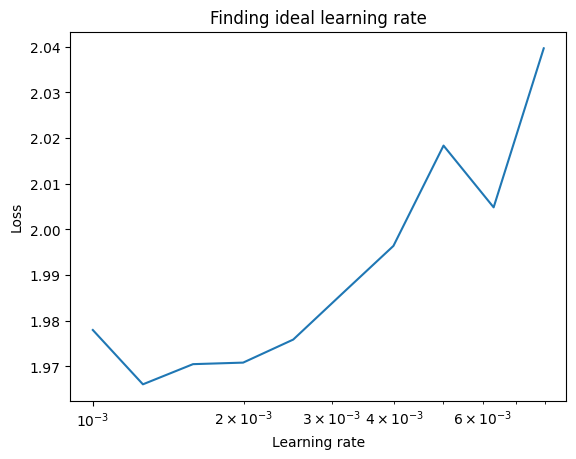

In [48]:
# Visualise Learn Rate Scheduler on Plot
lrs = 1e-3 * (10**(np.arange(10)/10))
plt.semilogx(lrs, conv_history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding ideal learning rate")
plt.show()

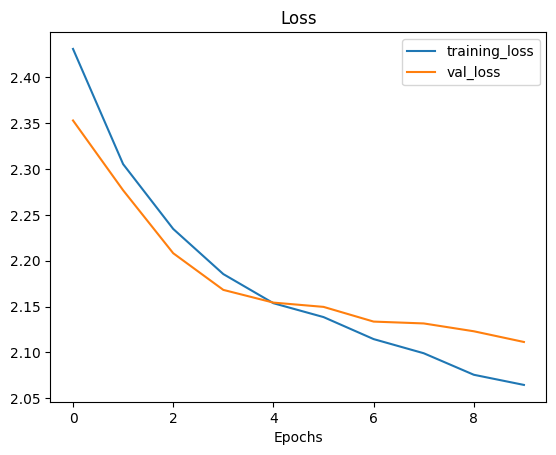

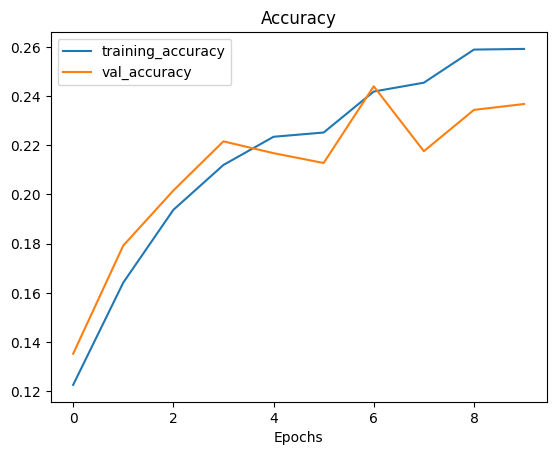

In [75]:
# plot loss curves from history
plot_loss_curves(conv_history)

In summary best learn rate between - 0.0013 and 0.0016

In [ ]:
# Set Input layer for input data
image_shape = None
for images in train_ds.take(1):
    image_shape = images[0].shape[1:]
print(f"image shape = {image_shape}")
inputs = Input(shape=image_shape, name="model_inputs")

In [ ]:
# Set data augmentation layer
x = data_augmentation(inputs)
# Set Convolution layers
x = Conv2D(32, 3, padding="same", activation="relu")(x)
x = Conv2D(32, 3, padding="same", activation="relu")(x)
# Set Max Pooling 2D layer
x = MaxPool2D()(x)
# Set another Convolution layers
x = Conv2D(16, 3, padding="same", activation="relu")(x)
x = Conv2D(16, 3, padding="same", activation="relu")(x)
# Set another Max Pooling 2D layer
x = MaxPool2D()(x)
# Set Flatten and finish Dense (Fully connected) layers
x = GlobalMaxPool2D(name="global_average_pooling_layer")(x)
# x = Dense(128, activation="relu")(x)
outputs = Dense(num_image_classes, activation="softmax")(x)

In [ ]:
# Define model object
conv2_model = Model(inputs, outputs, name="convolution_model")

In [ ]:
# Compile the model
model_compile(conv2_model, CategoricalCrossentropy(), learn_rate=0.0015)

In [56]:
# Fit model with train and test data
conv_history = conv_model.fit(train_ds,
                              batch_size=batch_size,
                              epochs=10,
                              validation_data=val_ds,
                              use_multiprocessing=True,
                              )

Epoch 1/10
235/235 [==============================] - 69s 289ms/step - loss: 2.0457 - accuracy: 0.2768 - val_loss: 2.0024 - val_accuracy: 0.2968
Epoch 2/10
235/235 [==============================] - 69s 291ms/step - loss: 2.0391 - accuracy: 0.2745 - val_loss: 2.0612 - val_accuracy: 0.2920
Epoch 3/10
235/235 [==============================] - 68s 287ms/step - loss: 2.0453 - accuracy: 0.2748 - val_loss: 2.0645 - val_accuracy: 0.2720
Epoch 4/10
207/235 [=========================>....] - ETA: 8s - loss: 2.0233 - accuracy: 0.2867

KeyboardInterrupt: 

## Evaluate model

In [15]:
loss, accuracy = conv_model.evaluate(test_ds)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {accuracy}")

79/79 [==============================] - 7s 89ms/step - loss: 5.7694 - accuracy: 0.1672
Model loss on the test set: 5.769413471221924
Model accuracy on the test set: 0.1671999990940094


In summary, we have that result:
**model** -- Convolution Neural Network (CNN)
**result** -- accuracy = ; loss = ;

## Exercise 3

#### Downloading Dataset
Our dataset is Emotion Detection from Text (from [kaggle](https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text?resource=download))